<a href="https://colab.research.google.com/github/Robin-01/California-Coastal-Sea-Currents/blob/main/ml_wind_currents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 18.3 MB/s eta 0:00:00


In [ ]:
import cartopy
import numpy as np                 #for general calculations.
import matplotlib.pyplot as plt    #making plots.
import xarray as xr                #loading and working with data in an optimal way.

from matplotlib.animation import FuncAnimation  #creating animations and videos.
from IPython.display import Video, HTML         #embedding videos in the notebook
from matplotlib.patches import Rectangle

import cartopy.crs as ccrs         # to plot maps with different projections
import cartopy.feature as cfeature # to plot coastlines, land, borders, etc.

#this command allows interactive plots in noteboks
%matplotlib inline

In [ ]:
#Specify the data file to load
USWC_6_km='/content/drive/MyDrive/DSO/Group Project/uswc_6km_Resolution_Hourly_RTV_best_2024_2025.nc4'
curr_ds = xr.open_dataset(USWC_6_km)  #xarray can open different format data, netcdf is one of them
wind_d = '/content/drive/MyDrive/DSO/UW_DSO_Project/Wind Data/wind_california.nc'
wind_ds = xr.open_dataset(wind_d)

In [ ]:
# Daily mean for wind (6-hourly → daily)
wind_daily = wind_ds.resample(time="1D").mean()
print(1)
# Daily mean for ocean currents (1-hourly → daily)
curr_daily = curr_ds.resample(time="1D").mean()


1


In [ ]:
# Shift longitudes
wind_daily = wind_daily.assign_coords(
    longitude = (((wind_daily.longitude + 180) % 360) - 180)
)

In [ ]:
curr_daily

<xarray.Dataset> Size: 354MB
Dimensions:  (time: 515, lat: 367, lon: 234)
Coordinates:
  * lat      (lat) float32 1kB 30.25 30.3 30.36 30.41 ... 49.88 49.94 49.99
  * lon      (lon) float32 936B -130.4 -130.3 -130.2 ... -115.9 -115.9 -115.8
  * time     (time) datetime64[ns] 4kB 2024-01-01 2024-01-02 ... 2025-05-29
Data variables:
    u        (time, lat, lon) float32 177MB nan nan nan nan ... nan nan nan nan
    wgs84    (time) float64 4kB -127.0 -127.0 -127.0 ... -127.0 -127.0 -127.0
    v        (time, lat, lon) float32 177MB nan nan nan nan ... nan nan nan nan
Attributes: (12/31)
    Conventions:               CF-1.4, ACDD-1.3
    id:                        202505141600siohfruwlsrtvuswc6km
    date_created:              2025-05-14T18:24:43Z
    source:                    surface ocean velocity field from hf-radar
    program:                   Integrated Ocean Observing System (IOOS)
    title:                     Near-Real Time Surface Ocean Velocity, U.S. We...
    ...                        ...
    format_version:            1.1.00
    product_version:           2.0.00
    cdm_data_type:             GRID
    featureType:               GRID
    location:                  Proto fmrc:HFRADAR_US_West_Coast_6km_Resolutio...
    History:                   Translated to CF-1.0 Conventions by Netcdf-Jav...

In [ ]:
wind_on_ocean_grid = wind_daily.interp(
    latitude=curr_daily.lat,
    longitude=curr_daily.lon,
    method="linear"
)

In [ ]:
wind_on_ocean_grid

<xarray.Dataset> Size: 503MB
Dimensions:    (time: 366, lat: 367, lon: 234)
Coordinates:
  * time       (time) datetime64[ns] 3kB 2024-01-01 2024-01-02 ... 2024-12-31
    latitude   (lat) float32 1kB 30.25 30.3 30.36 30.41 ... 49.88 49.94 49.99
    longitude  (lon) float32 936B -130.4 -130.3 -130.2 ... -115.9 -115.9 -115.8
  * lat        (lat) float32 1kB 30.25 30.3 30.36 30.41 ... 49.88 49.94 49.99
  * lon        (lon) float32 936B -130.4 -130.3 -130.2 ... -115.9 -115.9 -115.8
Data variables:
    uwnd       (time, lat, lon) float32 126MB 4.561 4.606 4.651 ... 0.195 0.1228
    vwnd       (time, lat, lon) float32 126MB -7.278 -7.309 ... -0.0501 -0.05611
    ws         (time, lat, lon) float32 126MB 8.7 8.749 8.799 ... 0.2543 0.2453
    nobs       (time, lat, lon) float32 126MB 1.743 1.711 1.68 ... 0.0 0.0 0.0
Attributes: (12/54)
    contact:                       Remote Sensing Systems, support@remss.com
    Conventions:                   CF-1.7 ACDD-1.3
    data_structure:                grid
    title:                         RSS CCMP V3.1 6-hourly surface winds (Leve...
    summary:                       RSS VAM 6-hour analyses using ERA-5 wind r...
    institute_id:                  RSS
    ...                            ...
    time_coverage_end:             2024-01-01T23:59:59Z
    platform:                      Space-based Platforms>Earth Observation Sa...
    instrument:                    Earth Remote Sensing Instruments>Passive R...
    history:                       2024-07-18T13:07:56.387608Z - netCDF gener...
    base_date:                     Y2024 M01 D01
    date_created:                  2024-07-18T13:07:56.387608Z

In [ ]:

# Merge into a single Dataset
ds_merged = xr.Dataset({
    "wind_u": wind_on_ocean_grid["uwnd"],
    "wind_v": wind_on_ocean_grid["vwnd"],
    "curr_u": curr_daily["u"],
    "curr_v": curr_daily["v"]
})

# Convert to pandas DataFrame (lat/lon/time kept as columns)
df = ds_merged.to_dataframe().reset_index()

# Final clean dataframe
df = df.dropna()

print(df.head())
print(df.columns)
df['wind_u'].max()

           time       lat         lon  latitude   longitude    wind_u  \
6974 2024-01-01  31.81426 -118.616508  31.81426 -118.616508 -3.314885   
7206 2024-01-01  31.86820 -118.741432  31.86820 -118.741432 -3.676177   
7208 2024-01-01  31.86820 -118.616508  31.86820 -118.616508 -3.491457   
7209 2024-01-01  31.86820 -118.554039  31.86820 -118.554039 -3.403176   
7436 2024-01-01  31.92214 -118.991295  31.92214 -118.991295 -4.120400   

        wind_v    curr_u    curr_v  
6974  2.461916 -0.053333 -0.046667  
7206  2.089027 -0.060000  0.027500  
7208  2.318537 -0.055000 -0.020000  
7209  2.375297 -0.190000  0.030000  
7436  1.471786  0.020000 -0.040000  
Index(['time', 'lat', 'lon', 'latitude', 'longitude', 'wind_u', 'wind_v',
       'curr_u', 'curr_v'],
      dtype='object')


15.874320030212402

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Features and targets
X = df[["wind_u", "wind_v", "lat", "lon"]].values  # adding spatial info
y = df[["curr_u", "curr_v"]].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Random Forest with multicore CPU
rf = RandomForestRegressor(
    n_estimators=100,  # more trees for better accuracy
    n_jobs=-1,          # use all CPU cores
    random_state=42
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))



KeyboardInterrupt: 

/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


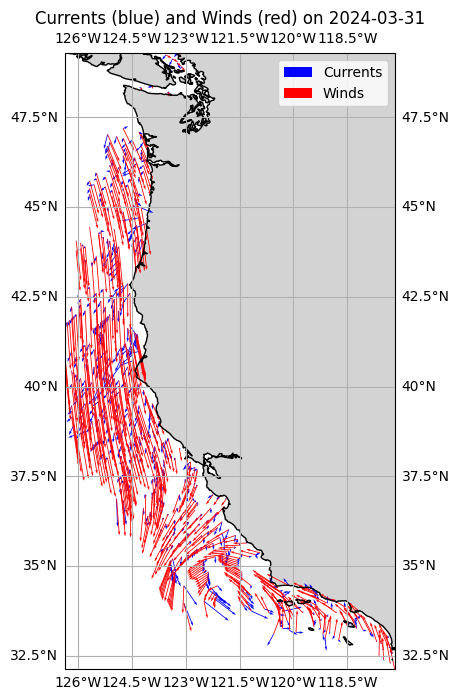

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Pick a day
date = "2024-03-31"

# Select data from the dataframe
df_day = df[df["time"] == date]

# Extract variables
lats = df_day["lat"].values
lons = df_day["lon"].values
u_curr = df_day["curr_u"].values
v_curr = df_day["curr_v"].values
u_wind = df_day["wind_u"].values
v_wind = df_day["wind_v"].values

# Control density of quiver arrows
skip = 15  # increase number to thin arrows more
lats = lats[::skip]
lons = lons[::skip]
u_curr = u_curr[::skip]
v_curr = v_curr[::skip]
u_wind = u_wind[::skip]
v_wind = v_wind[::skip]

# Plot
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="white")
ax.gridlines(draw_labels=True)

# Plot currents (blue)
plt.quiver(lons, lats, u_curr, v_curr, scale=10, color="blue", transform=ccrs.PlateCarree(), label="Currents")

# Plot winds (red)
plt.quiver(lons, lats, u_wind, v_wind, scale=100, color="red", transform=ccrs.PlateCarree(), label="Winds")

plt.title(f"Currents (blue) and Winds (red) on {date}")
plt.legend()
plt.show()


In [ ]:
df["wind_speed"] = np.sqrt(df["wind_u"]**2 + df["wind_v"]**2)
df["wind_dir"] = np.arctan2(df["wind_v"], df["wind_u"])
# Correct lagging: shift by time for each grid point
lag_features = ["wind_u", "wind_v", "curr_u", "curr_v"]

for feat in lag_features:
    df[f"{feat}_lag1"] = df.groupby(["lat", "lon"])[feat].shift(1)

# Drop rows with NaNs created by lagging (first time step for each location)
df = df.dropna(subset=[f"{feat}_lag1" for feat in lag_features])

df["month"] = df["time"].dt.month
df["day_of_year"] = df["time"].dt.dayofyear
#df = df.dropna(subset=["wind_u_lag1", "wind_v_lag1", "curr_u_lag1", "curr_v_lag1"])


/tmp/ipython-input-870276990.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["month"] = df["time"].dt.month
/tmp/ipython-input-870276990.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["day_of_year"] = df["time"].dt.dayofyear


In [ ]:
df

,time,lat,lon,latitude,longitude,wind_u,wind_v,curr_u,curr_v,wind_speed,wind_dir,wind_u_lag1,wind_v_lag1,curr_u_lag1,curr_v_lag1,month,day_of_year
178965,2024-01-03,31.868200,-118.554039,31.868200,-118.554039,5.498743,-3.778946,0.220000,-0.104000,6.672077,-0.602110,0.548075,-3.008246,0.135000,-0.190000,1,3
179192,2024-01-03,31.922140,-118.991295,31.922140,-118.991295,5.739769,-3.873851,0.140000,-0.070000,6.924714,-0.593691,1.091681,-3.656812,0.010000,-0.180000,1,3
179196,2024-01-03,31.922140,-118.741432,31.922140,-118.741432,5.602604,-3.773985,0.177500,-0.198750,6.755157,-0.592796,0.797971,-3.266301,0.130000,-0.140000,1,3
179198,2024-01-03,31.922140,-118.616508,31.922140,-118.616508,5.539913,-3.732809,0.152500,-0.186250,6.680158,-0.592927,0.662160,-3.031320,0.310000,-0.330000,1,3
179199,2024-01-03,31.922140,-118.554039,31.922140,-118.554039,5.517015,-3.736750,0.200000,-0.100000,6.663389,-0.595338,0.616078,-2.890595,0.215000,-0.320000,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31428414,2024-12-31,49.344761,-123.613739,49.344761,-123.613739,-2.513155,0.840615,0.144583,0.332917,2.650016,2.818805,-1.934309,0.812192,0.073333,0.411250,12,366
31428415,2024-12-31,49.344761,-123.551270,49.344761,-123.551270,-2.415154,0.755285,0.081667,0.263750,2.530498,2.838501,-1.878537,0.832299,0.078750,0.312083,12,366
31428416,2024-12-31,49.344761,-123.488808,49.344761,-123.488808,-2.317163,0.669965,0.013750,0.143750,2.412074,2.860137,-1.822772,0.852404,0.038333,0.128333,12,366
31428651,2024-12-31,49.398701,-123.426338,49.398701,-123.426338,-2.021173,0.565536,-0.117083,0.055000,2.098802,2.868764,-1.663042,0.728938,-0.075417,0.014167,12,366


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Features and targets
X = df[["wind_u", "wind_v", "lat", "lon", "wind_speed", "wind_dir", "wind_u_lag1", "wind_v_lag1", "curr_u_lag1", "curr_v_lag1", "month", "day_of_year"]].values
y = df[["curr_u", "curr_v"]].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Build an improved feedforward NN
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(2)  # predicting curr_u and curr_v
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mse', 'mae'])  # adding MAE too

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=200,
                    batch_size=256,
                    callbacks=[early_stop],
                    verbose=1)

# Predict
y_pred = model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2_u = r2_score(y_test[:,0], y_pred[:,0])
r2_v = r2_score(y_test[:,1], y_pred[:,1])

print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R² curr_u: {r2_u:.3f}")
print(f"R² curr_v: {r2_v:.3f}")

# Plot training history
import matplotlib.pyplot as plt
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Val MSE')
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.title("Training vs Validation Error")
plt.show()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
7887/7887 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 2/200
7887/7887 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 3/200
7887/7887 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 4/200
4433/7887 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: nan - mae: nan - mse: nan

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Features and targets
X = df[["wind_u", "wind_v", "lat", "lon", "wind_speed", "wind_dir",
        "wind_u_lag1", "wind_v_lag1", "curr_u_lag1", "curr_v_lag1",
        "month", "day_of_year"]].values
y = df[["curr_u", "curr_v"]].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features and targets
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Smaller, faster neural network
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(2)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mse', 'mae'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(X_train_scaled, y_train_scaled,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=512,
                    callbacks=[early_stop],
                    verbose=1)

# Predict
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2_u = r2_score(y_test[:,0], y_pred[:,0])
r2_v = r2_score(y_test[:,1], y_pred[:,1])

print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R² curr_u: {r2_u:.3f}")
print(f"R² curr_v: {r2_v:.3f}")

# Plot training history
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Val MSE')
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.title("Training vs Validation Error")
plt.show()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Features and targets
X = df[["wind_u", "wind_v", "lat", "lon", "wind_speed", "wind_dir",
        "wind_u_lag1", "wind_v_lag1", "curr_u_lag1", "curr_v_lag1",
        "month", "day_of_year"]].values
y = df[["curr_u", "curr_v"]].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Smaller, faster neural network
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(2)  # predict curr_u and curr_v
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mse', 'mae'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=512,
                    callbacks=[early_stop],
                    verbose=1)

# Predict
y_pred = model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2_u = r2_score(y_test[:,0], y_pred[:,0])
r2_v = r2_score(y_test[:,1], y_pred[:,1])

print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R² curr_u: {r2_u:.3f}")
print(f"R² curr_v: {r2_v:.3f}")

# Plot training history
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Val MSE')
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.title("Training vs Validation Error")
plt.show()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3916/3916 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 20.3694 - mae: 0.9236 - mse: 20.3694 - val_loss: 0.0317 - val_mae: 0.1492 - val_mse: 0.0317
Epoch 2/50
3916/3916 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.0369 - mae: 0.1270 - mse: 0.0369 - val_loss: 0.1839 - val_mae: 0.3081 - val_mse: 0.1839
Epoch 3/50
3916/3916 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.0474 - mae: 0.1441 - mse: 0.0474 - val_loss: 0.0110 - val_mae: 0.0766 - val_mse: 0.0110
Epoch 4/50
3916/3916 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0306 - mae: 0.1229 - mse: 0.0306 - val_loss: 0.0801 - val_mae: 0.2053 - val_mse: 0.0801
Epoch 5/50
3916/3916 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0232 - mae: 0.1089 - mse: 0.0232 - val_loss: 0.0111 - val_mae: 0.0774 - val_mse: 0.0111
Epoch 6/50
2592/3916 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0203 - mae: 0.1017 - mse: 0.0203

KeyboardInterrupt: 

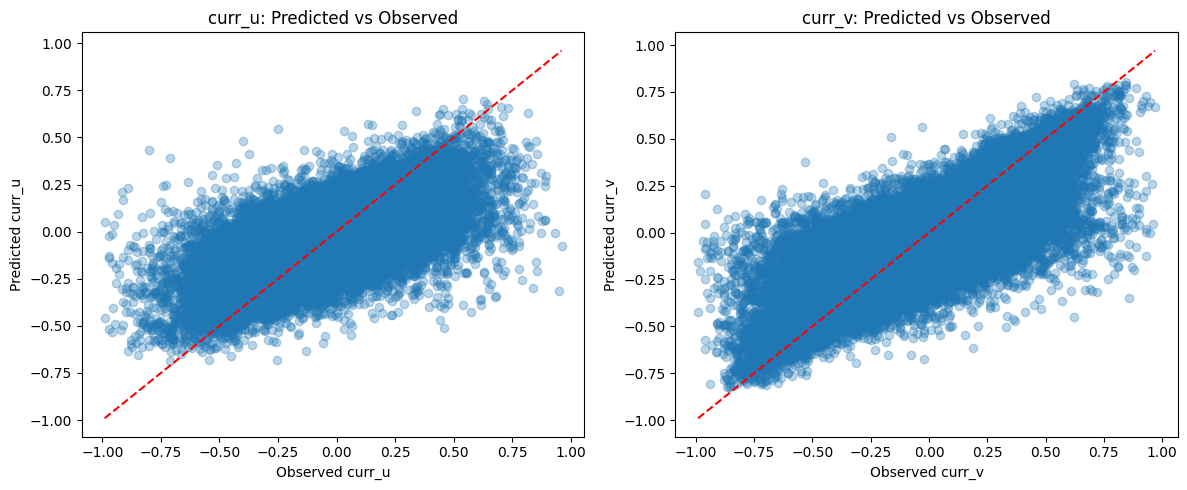

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Curr_u
plt.subplot(1, 2, 1)
plt.scatter(y_test[:, 0], y_pred[:, 0], alpha=0.3)
plt.xlabel('Observed curr_u')
plt.ylabel('Predicted curr_u')
plt.title('curr_u: Predicted vs Observed')
plt.plot([y_test[:,0].min(), y_test[:,0].max()],
         [y_test[:,0].min(), y_test[:,0].max()], 'r--')

# Curr_v
plt.subplot(1, 2, 2)
plt.scatter(y_test[:, 1], y_pred[:, 1], alpha=0.3)
plt.xlabel('Observed curr_v')
plt.ylabel('Predicted curr_v')
plt.title('curr_v: Predicted vs Observed')
plt.plot([y_test[:,1].min(), y_test[:,1].max()],
         [y_test[:,1].min(), y_test[:,1].max()], 'r--')

plt.tight_layout()
plt.show()
